### Example 7.1: Navier-Stokes Cavity Flow

Now that we've built up enough knowledge over the past few tutorials, we can now take a look at something a bit more developed.

In this tutorial, we'll take a look at how we can implement the Navier-Stokes equations using Devito. This is based off the final 2 parts of Lorena Barba's <i>CFD Python: 12 steps to Navier-Stokes</i>, found <a href="http://nbviewer.jupyter.org/github/barbagroup/CFDPython/blob/master/lessons/15_Step_11.ipynb">here</a> and <a href="http://nbviewer.jupyter.org/github/barbagroup/CFDPython/blob/master/lessons/16_Step_12.ipynb">here</a> respectively.

<b>Part 1: Implementing cavity flow</b>

It will take a while to set up all the equations before we can output any diagrams. Before we start with our usual variable declarations, we need to make a note on the equations used in the original Lorena Barba tutorial. 

At the top of the tutorial we are given the equations 

Let's begin with our usual variable declarations. Before we do that, there's a small update we need to make to the equations used in the original python tutorial. We want to use the equations at the top of the tutorial (without all the rearranging)

Our boundary conditions will be defined as:

$u=1$ at $y=2$

$u, v = 0$

$\frac{\partial p}{\partial y}=0$ at $y=0$

$p=0$ at $y=2$

$\frac{\partial p}{\partial x}=0$ at $x=0,2$

In [258]:
from matplotlib import pyplot, cm
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

In [259]:
# assign initial conditions
u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
p = np.zeros((nx, ny))
b = np.zeros((nx, ny))

Now we define the following functions for us to calculate flow:

In [260]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

In [261]:
def pressure_poisson(p, dx, dy, b):
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dy = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0     at y = 2
        
    return p

In [262]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
        u[-1, :] = 1 # set velocity on cavity lid to 1
        
        v[0, :] = 0
        v[-1, :]= 0
        v[:, 0] = 0
        v[:, -1] = 0
        
        
    return u, v, p

In [263]:
def plot_contour(X, Y, p, u, v):
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    # plotting the pressure field as a contour
    pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
    pyplot.colorbar()
    # plotting the pressure field outlines
    pyplot.contour(X, Y, p, cmap=cm.viridis)  
    # plotting velocity field
    pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
    pyplot.xlabel('X')
    pyplot.ylabel('Y')

Now let's try running this and see what it gives us. Let's start with nt = 100, then try again with a higher value for nt so we can compare the two.

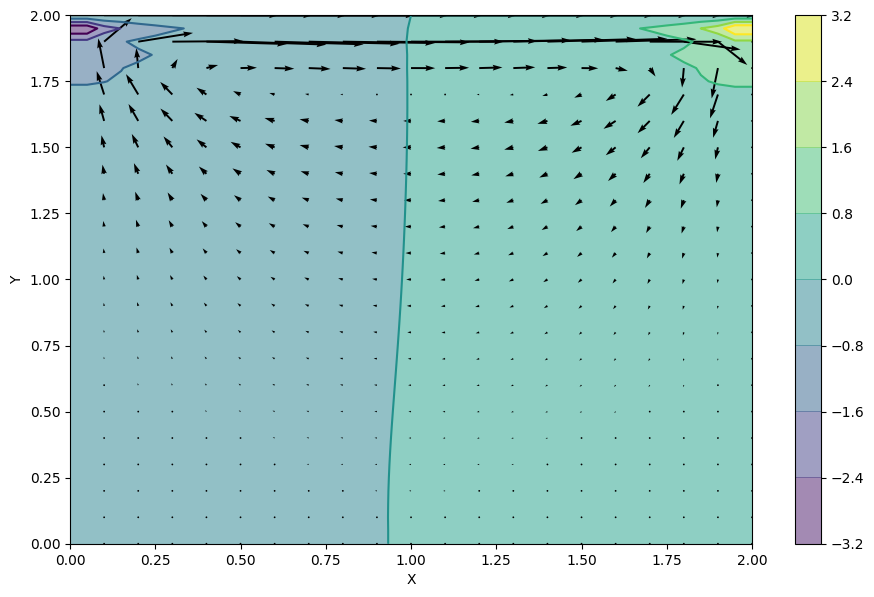

In [264]:
u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
p = np.zeros((nx, ny))
b = np.zeros((nx, ny))
nt = 100
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

plot_contour(X, Y, p, u, v)

Now again with a higher value for nt. In this example we use nt = 700.

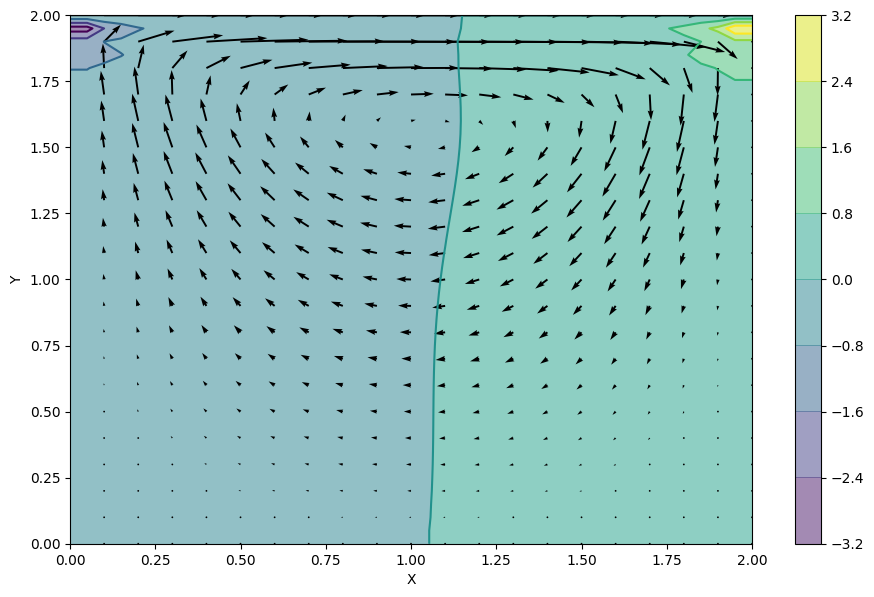

In [265]:
u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
p = np.zeros((nx, ny))
b = np.zeros((nx, ny))
nt = 700
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

plot_contour(X, Y, p, u, v)

<b>Devito Implementation</b>

Now let's go through using Devito and see how we can go about implementing the same thing. To begin with, we'll need TimeData objects to represent this space, and an equation to go with it. The equation we'll be using is

$$\frac{\partial\vec{v}}{\partial t} + (\vec{v} \cdot \nabla)\vec{v} = - \frac{1}{\rho}\nabla p + \nu \nabla^2 \vec{v}$$

as in Lorena Barba's notes. This splits up into 3 equations for u, v, and p (pressure) respectively. Explicitly, we'll have to use the equations

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x} + \nu\Big(\frac{\partial^2u}{\partial x^2}+\frac{\partial^2u}{\partial y^2}\Big)$$

$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y} + \nu\Big(\frac{\partial^2v}{\partial x^2}+\frac{\partial^2v}{\partial y^2}\Big)$$

$$\frac{\partial^2p}{\partial x^2}+\frac{\partial^2p}{\partial y^2} = -\rho\Big(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x} + 2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x} + \frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\Big)$$

Remember that our boundary conditions are:

$u=1$ at $y=2$

$u, v = 0$

$\frac{\partial p}{\partial y}=0$ at $y=0$

$p=0$ at $y=2$

$\frac{\partial p}{\partial x}=0$ at $x=0,2$

In [266]:
from devito import Operator, TimeData, left, x, y, t
from sympy import Eq, solve
from sympy.abc import h, s

from devito.finite_difference import first_derivative, left, right

def mydl(u, dim):
    return first_derivative(u, dim=dim, order=1, side=left)

# First create the space we need for this model
u = TimeData(name='u', shape=(nx, ny), space_order=2)
u.data.fill(0.)
v = TimeData(name='v', shape=(nx, ny), space_order=2)
v.data.fill(0.)
p = TimeData(name='p', shape=(nx, ny), space_order=2)
p.data.fill(0.)
# Set up the equation as above
# For u and v's momentum equations
u_eq = Eq(u.dt + u*mydl(u, x) + v*mydl(u, y), -1/rho*p.forward.dx + nu*u.laplace)
v_eq = Eq(v.dt + u*mydl(v, x) + v*mydl(v, y), -1/rho*p.forward.dy + nu*v.laplace)
# For p's pressure equation
p_eq = Eq(p.laplace, -rho*((u.dx)**2 + 2*(u.dy)*(v.dx) + (v.dy)**2) + rho/s*(u.dx+v.dy))
                 
# Set up our stencils
stencil_u = solve(u_eq, u.forward)[0]
stencil_v = solve(v_eq, v.forward)[0]
stencil_p = solve(p_eq, p)[0]

update_u = Eq(u.forward, stencil_u)
update_v = Eq(v.forward, stencil_v)
update_p = Eq(p.forward, stencil_p) # Bug Here

# Set Dirichlet boundary conditions using the low-level API, all equal to 1
bc_u = [Eq(u.indexed[t+1, 0, y], 0.)]      # left
bc_u += [Eq(u.indexed[t+1, nx-1, y], 0.)]  # right
bc_u += [Eq(u.indexed[t+1, x, ny-1], 1.)]  # top
bc_u += [Eq(u.indexed[t+1, x, 0], 0.)]     # bottom
bc_v = [Eq(v.indexed[t+1, 0, y], 0.)]      # left
bc_v += [Eq(v.indexed[t+1, nx-1, y], 0.)]  # right
bc_v += [Eq(v.indexed[t+1, x, ny-1], 0.)]  # top
bc_v += [Eq(v.indexed[t+1, x, 0], 0.)]     # bottom

bc_p = [Eq(p.indexed[t+1, 0, y], p.indexed[t+1, 1, y])]      # left
bc_p += [Eq(p.indexed[t+1, nx-1, y], p.indexed[t+1, nx-2, y])]  # right
bc_p += [Eq(p.indexed[t+1, x, ny-1], 0.)]  # top
bc_p += [Eq(p.indexed[t+1, x, 0], p.indexed[t+1, x, 1])]     # bottom

Now that we have that set up, let's make the operator that we need for this set of equations.

In [267]:
# Create the Operator
op = Operator([update_p] + bc_p + [update_u] + [update_v] + bc_u + bc_v, subs={h:dx, s:dt},
             dse=None, dle=None)

# Execute for a number of timesteps using nt from earlier
op(time=nt+1, u=u, v=v, p=p)

CustomCompiler: compiled /var/folders/2m/jkvdv5_d01d3m6pflwz441wh0000gn/T/devito-501/d88f7580e53db75da1ec2f781f917d381b862b33.c [0.19 s]
Section loop_y_1<701,40> with OI=0.00 computed in 0.000 s [Perf: 0.00 GFlops/s]
Section loop_x_2<701,41> with OI=0.00 computed in 0.000 s [Perf: 0.00 GFlops/s]
Section loop_x_3<701,40> with OI=0.00 computed in 0.000 s [Perf: 0.00 GFlops/s]
Section loop_y_4<701,41> with OI=0.00 computed in 0.000 s [Perf: 0.00 GFlops/s]
Section main<701,40,40> with OI=3.21 computed in 0.030 s [Perf: 3.06 GFlops/s]


Printing all this is a bit different to last time and doesn't have an easy implementation integrated into Devito yet, so for now we'll have to define the printing function the same as plot_contour() above. Once we've done this we can take a look at our solution.

In [268]:
def plot_contour(X, Y, p, u, v):
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    # plotting the pressure field as a contour
    pyplot.contourf(Y, X, p, alpha=0.5, cmap=cm.viridis)  
    pyplot.colorbar()
    # plotting the pressure field outlines
    pyplot.contour(Y, X, p, cmap=cm.viridis)  
    # plotting velocity field
    pyplot.quiver(Y[::2, ::2], X[::2, ::2], v[::2, ::2], u[::2, ::2]) 
    pyplot.xlabel('X')
    pyplot.ylabel('Y')

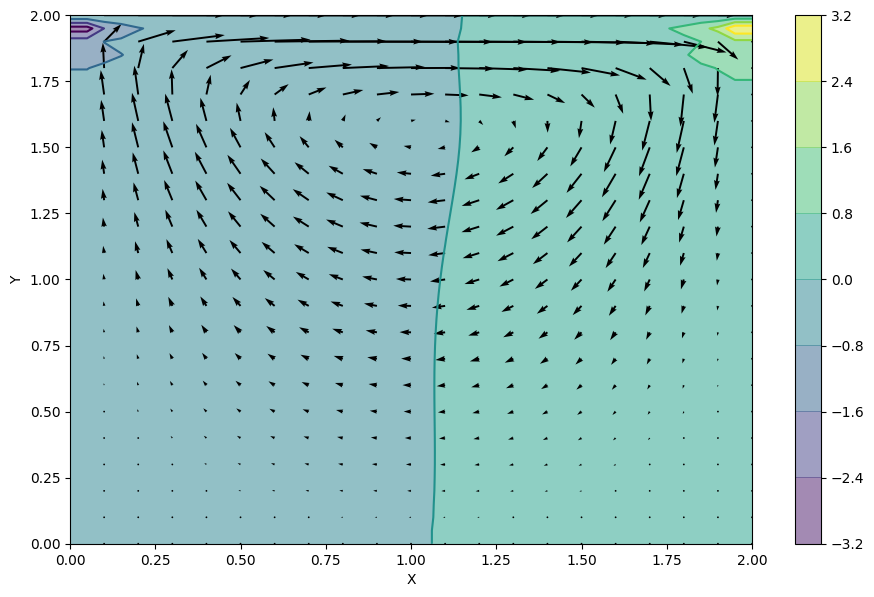

In [269]:
plot_contour(X, Y, p.data[1, :, :], v.data[1, :, :], u.data[1, :, :])

Perfect! That was exactly what we wanted. This means that we've successfully implemented cavity flow in Devito and been able to output it into a graph, which is what we wanted to do. In the next example we'll be continuing with Navier-Stokes equations, although with a slightly different example: channel flow. Click <a href="https://github.com/opesci/devito/blob/cfd-examples/examples/cfd/test_07_navier_stokes_channel_flow.ipynb">here</a> to go to the next tutorial.